In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
print(" Environment configured")


 Environment configured


In [2]:
import gc
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE
from scipy.signal import resample
from scipy.fft import fft
from scipy.stats import skew, kurtosis
import pywt

sns.set_style('whitegrid')
np.random.seed(42)
tf.random.set_seed(42)

print(f" TensorFlow: {tf.__version__}")
print(f" GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")


 TensorFlow: 2.13.0
 GPU Available: False


In [3]:
def load_csv_efficiently(filepath, target_length=15000):
    try:
        df = pd.read_csv(filepath, header=None, dtype=np.float32)
        signal_data = df.values[:, 0]
    except:
        chunks = []
        for chunk in pd.read_csv(filepath, header=None, dtype=np.float32, chunksize=50000):
            chunks.append(chunk.values[:, 0])
        signal_data = np.concatenate(chunks)
        del chunks
        gc.collect()

    if len(signal_data) != target_length:
        signal_data = resample(signal_data, target_length)

    return signal_data.astype(np.float32)

def load_dataset(base_path='archive', target_length=15000):
    X_signals, y_labels = [], []

    normal_files = glob(os.path.join(base_path, 'normal', '*.csv'))
    print(f" Loading {len(normal_files)} normal samples...")
    for i, file in enumerate(normal_files):
        if i % 10 == 0:
            print(f"  Progress: {i+1}/{len(normal_files)}")
        X_signals.append(load_csv_efficiently(file, target_length))
        y_labels.append(0)
        if i % 20 == 0:
            gc.collect()

    for folder in ['6g', '10g', '15g', '20g', '30g', '35g']:
        files = glob(os.path.join(base_path, 'imbalance', folder, '*.csv'))
        print(f" Loading {len(files)} samples from {folder}...")
        for i, file in enumerate(files):
            if i % 10 == 0:
                print(f"  Progress: {i+1}/{len(files)}")
            X_signals.append(load_csv_efficiently(file, target_length))
            y_labels.append(1)
            if i % 20 == 0:
                gc.collect()

    X_array = np.array(X_signals, dtype=np.float32)
    y_array = np.array(y_labels, dtype=np.int8)

    del X_signals, y_labels
    gc.collect()

    return X_array, y_array

print(" Loading functions defined")


 Loading functions defined


In [4]:
SIGNAL_LENGTH = 15000

print("="*70)
print("LOADING VIBRATION SIGNAL DATASET")
print("="*70)
print(f"Target signal length: {SIGNAL_LENGTH:,} samples")
print()

X_raw, y = load_dataset('archive', SIGNAL_LENGTH)

print(f"\n Dataset Summary:")
print(f"   Total samples: {len(X_raw)}")
print(f"   Signal length: {X_raw.shape[1]:,}")
print(f"   Memory: {X_raw.nbytes / (1024**2):.2f} MB")
print(f"\n Class Distribution:")
print(f"   Normal (0): {np.sum(y==0)} ({np.sum(y==0)/len(y)*100:.1f}%)")
print(f"   Imbalance (1): {np.sum(y==1)} ({np.sum(y==1)/len(y)*100:.1f}%)")

gc.collect()


LOADING VIBRATION SIGNAL DATASET
Target signal length: 15,000 samples

 Loading 49 normal samples...
  Progress: 1/49
  Progress: 11/49
  Progress: 21/49
  Progress: 31/49
  Progress: 41/49
 Loading 49 samples from 6g...
  Progress: 1/49
  Progress: 11/49
  Progress: 21/49
  Progress: 31/49
  Progress: 41/49
 Loading 48 samples from 10g...
  Progress: 1/48
  Progress: 11/48
  Progress: 21/48
  Progress: 31/48
  Progress: 41/48
 Loading 48 samples from 15g...
  Progress: 1/48
  Progress: 11/48
  Progress: 21/48
  Progress: 31/48
  Progress: 41/48
 Loading 49 samples from 20g...
  Progress: 1/49
  Progress: 11/49
  Progress: 21/49
  Progress: 31/49
  Progress: 41/49
 Loading 47 samples from 30g...
  Progress: 1/47
  Progress: 11/47
  Progress: 21/47
  Progress: 31/47
  Progress: 41/47
 Loading 45 samples from 35g...
  Progress: 1/45
  Progress: 11/45
  Progress: 21/45
  Progress: 31/45
  Progress: 41/45

 Dataset Summary:
   Total samples: 335
   Signal length: 15,000
   Memory: 19.17 MB

0

In [5]:
def augment_signal(signal, augmentation_factor=0.05):
    augmented = signal.copy()

    noise = np.random.normal(0, augmentation_factor * np.std(signal), len(signal))
    augmented += noise

    scale = np.random.uniform(0.95, 1.05)
    augmented *= scale

    shift = np.random.randint(-int(0.02*len(signal)), int(0.02*len(signal)))
    augmented = np.roll(augmented, shift)

    return augmented.astype(np.float32)

print(" Augmentation function defined")


 Augmentation function defined


In [6]:
print("Normalizing signals...")

X_normalized = np.zeros_like(X_raw)
for i in range(len(X_raw)):
    mean = np.mean(X_raw[i])
    std = np.std(X_raw[i])
    X_normalized[i] = (X_raw[i] - mean) / (std + 1e-8)
    if i % 50 == 0:
        print(f"  {i+1}/{len(X_raw)}")

X_cnn = X_normalized.reshape(-1, SIGNAL_LENGTH, 1).astype(np.float32)

print(f"\n CNN input shape: {X_cnn.shape}")
print(f"   Memory: {X_cnn.nbytes / (1024**2):.2f} MB")

del X_normalized
gc.collect()


Normalizing signals...
  1/335
  51/335
  101/335
  151/335
  201/335
  251/335
  301/335

 CNN input shape: (335, 15000, 1)
   Memory: 19.17 MB


30

In [7]:
def extract_features_for_rf(signal_data):
    features = []

    features.extend([
        np.mean(signal_data),
        np.std(signal_data),
        np.var(signal_data),
        np.max(signal_data),
        np.min(signal_data),
        np.median(signal_data),
        np.ptp(signal_data),
        np.sqrt(np.mean(signal_data**2)),
        skew(signal_data),
        kurtosis(signal_data),
        np.max(np.abs(signal_data)) / (np.sqrt(np.mean(signal_data**2)) + 1e-8),
        np.mean(np.abs(signal_data)),
        np.sqrt(np.mean(np.abs(signal_data))),
        np.percentile(signal_data, 25),
        np.percentile(signal_data, 75)
    ])

    fft_vals = np.abs(fft(signal_data))
    fft_vals = fft_vals[:len(fft_vals)//2]
    top_20 = np.sort(fft_vals)[-20:]
    features.extend(top_20)
    features.extend([
        np.mean(fft_vals),
        np.std(fft_vals),
        np.max(fft_vals),
        np.argmax(fft_vals),
        np.sum(fft_vals)
    ])

    coeffs = pywt.wavedec(signal_data, 'db4', level=4)
    for coeff in coeffs:
        features.extend([
            np.mean(coeff),
            np.std(coeff),
            np.max(np.abs(coeff))
        ])

    return np.array(features, dtype=np.float32)

print("Extracting features for Random Forest...")

X_features_rf = []
for i, sig in enumerate(X_raw):
    if i % 30 == 0:
        print(f"  {i+1}/{len(X_raw)}")
    X_features_rf.append(extract_features_for_rf(sig))
    if i % 50 == 0:
        gc.collect()

X_features_rf = np.array(X_features_rf, dtype=np.float32)
print(f"\n RF features: {X_features_rf.shape}")

gc.collect()


Extracting features for Random Forest...
(CNN will NOT use these!)

  1/335
  31/335
  61/335
  91/335
  121/335
  151/335
  181/335
  211/335
  241/335
  271/335
  301/335
  331/335

 RF features: (335, 55)


0

In [8]:
X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(
    X_cnn, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train_rf, X_test_rf, _, _ = train_test_split(
    X_features_rf, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("="*70)
print("TRAIN-TEST SPLIT")
print("="*70)
print(f"Train: {len(y_train)} samples")
print(f"Test:  {len(y_test)} samples")
print(f"\nTrain - Normal: {np.sum(y_train==0)}, Imbalance: {np.sum(y_train==1)}")
print(f"Test  - Normal: {np.sum(y_test==0)}, Imbalance: {np.sum(y_test==1)}")

print("\n" + "="*70)
print("APPLYING SMOTE")
print("="*70)

X_train_cnn_flat = X_train_cnn.reshape(X_train_cnn.shape[0], -1)
try:
    smote = SMOTE(random_state=42)
    X_train_cnn_smote_flat, y_train_smote = smote.fit_resample(X_train_cnn_flat, y_train)
    print(" SMOTE applied to CNN training data")
except:
    print("  SMOTE failed, using random oversampling...")
    minority_idx = np.where(y_train == 0)[0]
    majority_idx = np.where(y_train == 1)[0]
    n_add = len(majority_idx) - len(minority_idx)
    oversample_idx = np.random.choice(minority_idx, size=n_add, replace=True)
    all_idx = np.concatenate([np.arange(len(y_train)), oversample_idx])
    X_train_cnn_smote_flat = X_train_cnn_flat[all_idx]
    y_train_smote = y_train[all_idx]
    print(" Oversampling applied to CNN training data")

X_train_cnn_smote = X_train_cnn_smote_flat.reshape(-1, SIGNAL_LENGTH, 1).astype(np.float32)

try:
    smote_rf = SMOTE(random_state=42)
    X_train_rf_smote, y_train_rf_smote = smote_rf.fit_resample(X_train_rf, y_train)
    print(" SMOTE applied to RF training data")
except:
    X_train_rf_smote = X_train_rf[all_idx]
    y_train_rf_smote = y_train[all_idx]
    print(" Oversampling applied to RF training data")

print(f"\nAfter SMOTE:")
print(f"  Total: {len(y_train_smote)} samples")
print(f"  Normal: {np.sum(y_train_smote==0)}, Imbalance: {np.sum(y_train_smote==1)}")

del X_train_cnn_flat, X_train_cnn, X_cnn, X_raw
gc.collect()


TRAIN-TEST SPLIT
Train: 268 samples
Test:  67 samples

Train - Normal: 39, Imbalance: 229
Test  - Normal: 10, Imbalance: 57

APPLYING SMOTE
  SMOTE failed, using random oversampling...
 Oversampling applied to CNN training data
 Oversampling applied to RF training data

After SMOTE:
  Total: 458 samples
  Normal: 229, Imbalance: 229


26

In [9]:
def squeeze_excite_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]

    se = layers.GlobalAveragePooling1D()(input_tensor)

    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)

    se = layers.Reshape((1, channels))(se)
    return layers.multiply([input_tensor, se])

def residual_block(x, filters, kernel_size, stride=1):
    shortcut = x

    x = layers.Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def build_advanced_pure_cnn(input_shape):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv1D(64, 15, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(3, strides=2, padding='same')(x)

    x = residual_block(x, 64, 11)
    x = squeeze_excite_block(x)
    x = layers.Dropout(0.2)(x)

    x = residual_block(x, 128, 9, stride=2)
    x = squeeze_excite_block(x)
    x = layers.Dropout(0.25)(x)

    x = residual_block(x, 256, 7, stride=2)
    x = squeeze_excite_block(x)
    x = layers.Dropout(0.3)(x)

    x = residual_block(x, 512, 5, stride=2)
    x = squeeze_excite_block(x)
    x = layers.Dropout(0.35)(x)

    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='Pure_CNN_Advanced')
    return model

pure_cnn = build_advanced_pure_cnn(input_shape=(SIGNAL_LENGTH, 1))

print("="*70)
print("ADVANCED PURE CNN ARCHITECTURE")
print("="*70)
print("Features: Residual blocks + SE attention + Deep layers")
print("Input: RAW SIGNALS ONLY - No engineered features!")
print("="*70)
pure_cnn.summary()
print(f"\n Total parameters: {pure_cnn.count_params():,}")


ADVANCED PURE CNN ARCHITECTURE
Features: Residual blocks + SE attention + Deep layers
Input: RAW SIGNALS ONLY - No engineered features!
Model: "Pure_CNN_Advanced"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 15000, 1)]           0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 7500, 64)             1024      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 7500, 64)             256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                             

                                                                                                  
 reshape_1 (Reshape)         (None, 1, 128)               0         ['dense_3[0][0]']             
                                                                                                  
 multiply_1 (Multiply)       (None, 1875, 128)            0         ['activation_4[0][0]',        
                                                                     'reshape_1[0][0]']           
                                                                                                  
 dropout_1 (Dropout)         (None, 1875, 128)            0         ['multiply_1[0][0]']          
                                                                                                  
 conv1d_6 (Conv1D)           (None, 938, 256)             229632    ['dropout_1[0][0]']           
                                                                                                  
 batch_nor

                                                                     'reshape_3[0][0]']           
                                                                                                  
 dropout_3 (Dropout)         (None, 469, 512)             0         ['multiply_3[0][0]']          
                                                                                                  
 global_average_pooling1d_4  (None, 512)                  0         ['dropout_3[0][0]']           
  (GlobalAveragePooling1D)                                                                        
                                                                                                  
 dense_8 (Dense)             (None, 512)                  262656    ['global_average_pooling1d_4[0
                                                                    ][0]']                        
                                                                                                  
 batch_nor

In [10]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, augment=True, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indices = np.arange(len(self.X))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = self.X[batch_indices].copy()
        y_batch = self.y[batch_indices]

        if self.augment:
            for i in range(len(X_batch)):
                if np.random.rand() > 0.5:
                    X_batch[i, :, 0] = augment_signal(X_batch[i, :, 0])

        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

train_gen = DataGenerator(X_train_cnn_smote, y_train_smote, batch_size=32, augment=True)
val_gen = DataGenerator(X_test_cnn, y_test, batch_size=32, augment=False, shuffle=False)

print(" Data generators created with real-time augmentation")


 Data generators created with real-time augmentation


In [11]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_smote),
    y=y_train_smote
)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print(f"Class weights: {class_weights_dict}")

pure_cnn.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=30,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.5,
        patience=15,
        mode='max',
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_pure_cnn.h5',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=0
    )
]

print("\n" + "="*70)
print(" TRAINING PURE CNN (NO ENGINEERED FEATURES!)")
print("="*70)
print("Features:")
print("   Real-time data augmentation")
print("   Residual connections")
print("   SE attention blocks")
print("   Deep architecture")
print("   Class weighting")
print("   Patient early stopping")
print()

history = pure_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=150,
    class_weight=class_weights_dict,
    callbacks=callbacks_list,
    verbose=1
)

print("\n Pure CNN training complete!")
gc.collect()


Class weights: {0: 1.0, 1: 1.0}

 TRAINING PURE CNN (NO ENGINEERED FEATURES!)
Features:
   Real-time data augmentation
   Residual connections
   SE attention blocks
   Deep architecture
   Class weighting
   Patient early stopping

Epoch 1/150
15/15 [==============================] - 142s 8s/step - loss: 1.1808 - accuracy: 0.5349 - precision: 0.5312 - recall: 0.5939 - auc: 0.5244 - val_loss: 0.9326 - val_accuracy: 0.8507 - val_precision: 0.8507 - val_recall: 1.0000 - val_auc: 0.5000 - lr: 5.0000e-04
Epoch 2/150
15/15 [==============================] - 124s 8s/step - loss: 1.1026 - accuracy: 0.5284 - precision: 0.5274 - recall: 0.5459 - auc: 0.5526 - val_loss: 0.9113 - val_accuracy: 0.8507 - val_precision: 0.8507 - val_recall: 1.0000 - val_auc: 0.4737 - lr: 5.0000e-04
Epoch 3/150
15/15 [==============================] - 125s 8s/step - loss: 1.1122 - accuracy: 0.5349 - precision: 0.5323 - recall: 0.5764 - auc: 0.5418 - val_loss: 0.9534 - val_accuracy: 0.4776 - val_precision: 0.8667 - va

Epoch 60/150
15/15 [==============================] - ETA: 0s - loss: 0.5705 - accuracy: 0.8428 - precision: 0.8398 - recall: 0.8472 - auc: 0.9254
Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
15/15 [==============================] - 124s 9s/step - loss: 0.5705 - accuracy: 0.8428 - precision: 0.8398 - recall: 0.8472 - auc: 0.9254 - val_loss: 1.8319 - val_accuracy: 0.6418 - val_precision: 1.0000 - val_recall: 0.5789 - val_auc: 0.8868 - lr: 5.0000e-04
Epoch 61/150
15/15 [==============================] - 124s 8s/step - loss: 0.5818 - accuracy: 0.8275 - precision: 0.8000 - recall: 0.8734 - auc: 0.9228 - val_loss: 0.6200 - val_accuracy: 0.8955 - val_precision: 0.8906 - val_recall: 1.0000 - val_auc: 0.7789 - lr: 2.5000e-04
Epoch 62/150
15/15 [==============================] - 124s 8s/step - loss: 0.5655 - accuracy: 0.8297 - precision: 0.8133 - recall: 0.8559 - auc: 0.9266 - val_loss: 3.7165 - val_accuracy: 0.5075 - val_precision: 1.0000 - val_recall: 0.4211 - 

229

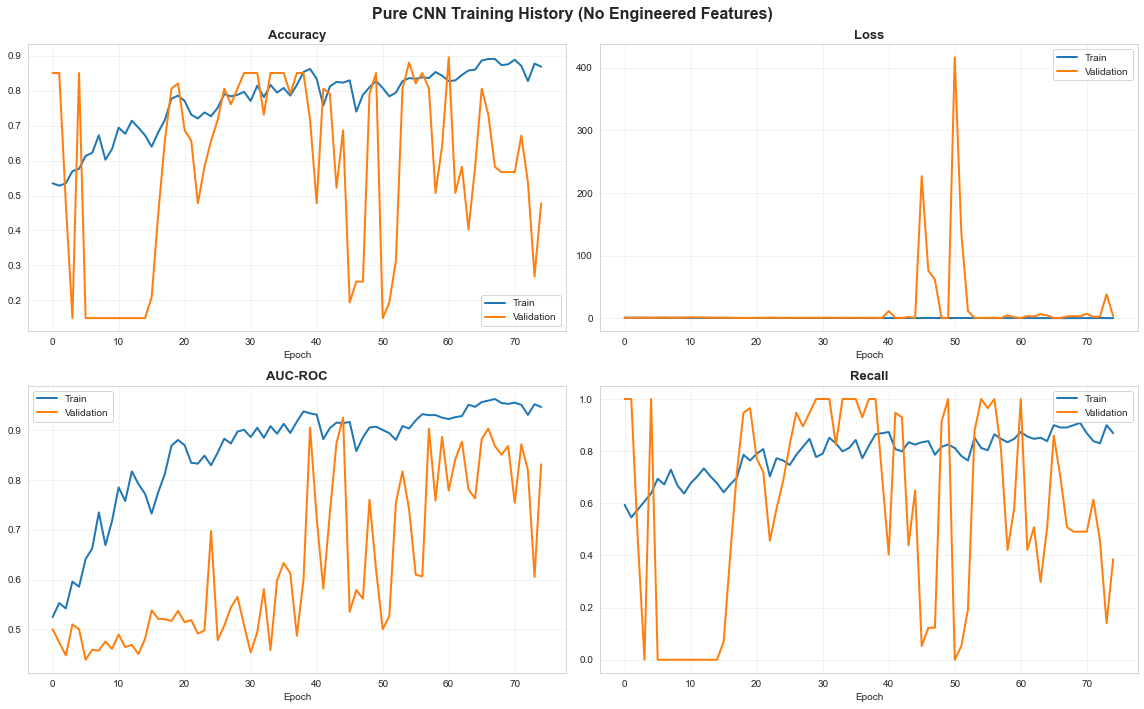

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Pure CNN Training History (No Engineered Features)', fontsize=16, fontweight='bold')

axes[0,0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0,0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0,0].set_title('Accuracy', fontweight='bold', fontsize=13)
axes[0,0].set_xlabel('Epoch')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(history.history['loss'], label='Train', linewidth=2)
axes[0,1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0,1].set_title('Loss', fontweight='bold', fontsize=13)
axes[0,1].set_xlabel('Epoch')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

axes[1,0].plot(history.history['auc'], label='Train', linewidth=2)
axes[1,0].plot(history.history['val_auc'], label='Validation', linewidth=2)
axes[1,0].set_title('AUC-ROC', fontweight='bold', fontsize=13)
axes[1,0].set_xlabel('Epoch')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(history.history['recall'], label='Train', linewidth=2)
axes[1,1].plot(history.history['val_recall'], label='Validation', linewidth=2)
axes[1,1].set_title('Recall', fontweight='bold', fontsize=13)
axes[1,1].set_xlabel('Epoch')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [30]:
print("="*70)
print("TRAINING TRADITIONAL ML MODELS ON RAW SIGNALS (NO FEATURES!)")
print("="*70)
print("Using SAME raw signal data as CNN - fair comparison!")
print()

print("Preparing raw signals for ML models...")

try:
    X_train_ml_raw = train_gen.X.reshape(train_gen.X.shape[0], -1)
    y_train_ml = train_gen.y
    print("   Using data from training generator")
except:
    print("  Recreating SMOTE'd training data...")

    X_train_cnn_temp, X_test_cnn_temp, y_train_temp, y_test_temp = train_test_split(
        X_cnn, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    X_train_flat = X_train_cnn_temp.reshape(X_train_cnn_temp.shape[0], -1)
    try:
        smote = SMOTE(random_state=42)
        X_train_smote_flat, y_train_ml = smote.fit_resample(X_train_flat, y_train_temp)
    except:
        minority_idx = np.where(y_train_temp == 0)[0]
        majority_idx = np.where(y_train_temp == 1)[0]
        n_add = len(majority_idx) - len(minority_idx)
        oversample_idx = np.random.choice(minority_idx, size=n_add, replace=True)
        all_idx = np.concatenate([np.arange(len(y_train_temp)), oversample_idx])
        X_train_smote_flat = X_train_flat[all_idx]
        y_train_ml = y_train_temp[all_idx]

    X_train_ml_raw = X_train_smote_flat

    X_test_cnn = X_test_cnn_temp

    del X_train_flat, X_train_cnn_temp, X_test_cnn_temp
    gc.collect()
    print("   Training data recreated")

X_test_ml_raw = X_test_cnn.reshape(X_test_cnn.shape[0], -1)

print(f"  Train shape: {X_train_ml_raw.shape}")
print(f"  Test shape:  {X_test_ml_raw.shape}")
print(f"  Features per sample: {X_train_ml_raw.shape[1]:,} (raw signal points)")

print("\n Training Logistic Regression on RAW SIGNALS...")
lr_model_raw = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    C=1.0,
    solver='saga',
    verbose=0
)
lr_model_raw.fit(X_train_ml_raw, y_train_ml)
print("   Logistic Regression (raw signals) trained")

print("\n Training Random Forest on RAW SIGNALS...")
print("  (This may take a few minutes...)")
rf_model_raw = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model_raw.fit(X_train_ml_raw, y_train_ml)
print("   Random Forest (raw signals) trained")

print("\n All models trained on RAW SIGNALS!")
print("   - Pure CNN: Raw signals")
print("   - Logistic Regression: Raw signals")
print("   - Random Forest: Raw signals")

del X_train_ml_raw
gc.collect()


TRAINING TRADITIONAL ML MODELS ON RAW SIGNALS (NO FEATURES!)
Using SAME raw signal data as CNN - fair comparison!

Preparing raw signals for ML models...
   Using data from training generator
  Train shape: (458, 15000)
  Test shape:  (67, 15000)
  Features per sample: 15,000 (raw signal points)

 Training Logistic Regression on RAW SIGNALS...
   Logistic Regression (raw signals) trained

 Training Random Forest on RAW SIGNALS...
  (This may take a few minutes...)
   Random Forest (raw signals) trained

 All models trained on RAW SIGNALS!
   - Pure CNN: Raw signals
   - Logistic Regression: Raw signals
   - Random Forest: Raw signals

   Now it's a FAIR FIGHT - everyone uses the same input!


42

In [31]:
def evaluate_model(y_true, y_pred, y_pred_proba, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n{'='*70}")
    print(f"{name.upper()}")
    print(f"{'='*70}")
    print(f"  Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {auc:.4f}")
    print(f"\n  Confusion Matrix:")
    print(f"  {cm}")

    tn, fp, fn, tp = cm.ravel()
    spec = tn/(tn+fp) if (tn+fp)>0 else 0
    print(f"\n  Specificity: {spec:.4f}")
    print(f"  Sensitivity: {rec:.4f}")

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc, 'cm': cm, 'spec': spec}

print("="*70)
print(" COMPREHENSIVE EVALUATION (ALL MODELS ON RAW SIGNALS)")
print("="*70)

print("\n[1/3] Evaluating Pure CNN...")
y_pred_cnn_proba = pure_cnn.predict(X_test_cnn, verbose=0).flatten()
y_pred_cnn = (y_pred_cnn_proba > 0.5).astype(int)
res_cnn = evaluate_model(y_test, y_pred_cnn, y_pred_cnn_proba, "Pure CNN (Raw Signals)")

print("\n[2/3] Evaluating Logistic Regression (Raw Signals)...")
y_pred_lr_raw = lr_model_raw.predict(X_test_ml_raw)
y_pred_lr_raw_proba = lr_model_raw.predict_proba(X_test_ml_raw)[:, 1]
res_lr_raw = evaluate_model(y_test, y_pred_lr_raw, y_pred_lr_raw_proba, "Logistic Regression (Raw Signals)")

print("\n[3/3] Evaluating Random Forest (Raw Signals)...")
y_pred_rf_raw = rf_model_raw.predict(X_test_ml_raw)
y_pred_rf_raw_proba = rf_model_raw.predict_proba(X_test_ml_raw)[:, 1]
res_rf_raw = evaluate_model(y_test, y_pred_rf_raw, y_pred_rf_raw_proba, "Random Forest (Raw Signals)")

print("\n All evaluations complete!")


 COMPREHENSIVE EVALUATION (ALL MODELS ON RAW SIGNALS)

[1/3] Evaluating Pure CNN...

PURE CNN (RAW SIGNALS)
  Accuracy:  0.6866 (68.66%)
  Precision: 0.9737
  Recall:    0.6491
  F1-Score:  0.7789
  ROC-AUC:   0.9263

  Confusion Matrix:
  [[ 9  1]
 [20 37]]

  Specificity: 0.9000
  Sensitivity: 0.6491

[2/3] Evaluating Logistic Regression (Raw Signals)...

LOGISTIC REGRESSION (RAW SIGNALS)
  Accuracy:  0.4925 (49.25%)
  Precision: 0.8286
  Recall:    0.5088
  F1-Score:  0.6304
  ROC-AUC:   0.5070

  Confusion Matrix:
  [[ 4  6]
 [28 29]]

  Specificity: 0.4000
  Sensitivity: 0.5088

[3/3] Evaluating Random Forest (Raw Signals)...

RANDOM FOREST (RAW SIGNALS)
  Accuracy:  0.8507 (85.07%)
  Precision: 0.8507
  Recall:    1.0000
  F1-Score:  0.9194
  ROC-AUC:   0.6719

  Confusion Matrix:
  [[ 0 10]
 [ 0 57]]

  Specificity: 0.0000
  Sensitivity: 1.0000

 All evaluations complete!


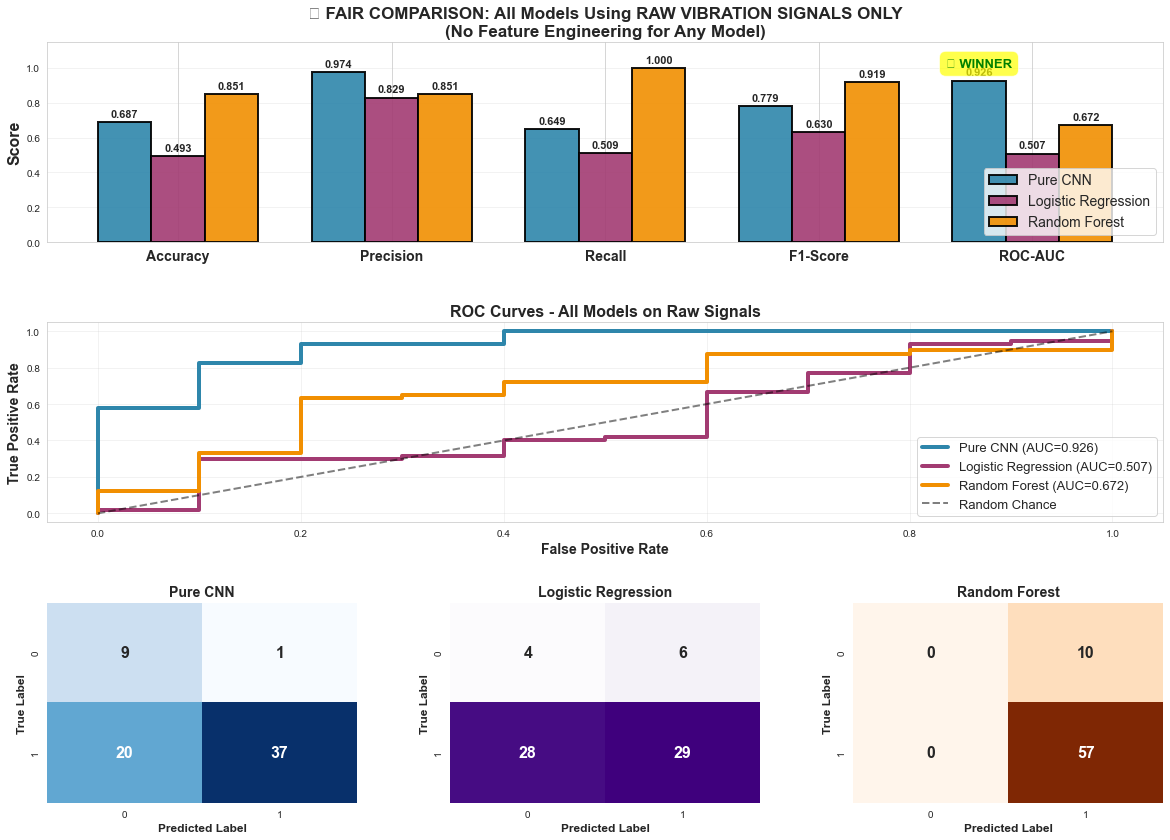


 Visualization saved as 'fair_comparison_all_raw_signals.png'


In [33]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :])
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.25

cnn_vals = [res_cnn['acc'], res_cnn['prec'], res_cnn['rec'], res_cnn['f1'], res_cnn['auc']]
lr_vals = [res_lr_raw['acc'], res_lr_raw['prec'], res_lr_raw['rec'], res_lr_raw['f1'], res_lr_raw['auc']]
rf_vals = [res_rf_raw['acc'], res_rf_raw['prec'], res_rf_raw['rec'], res_rf_raw['f1'], res_rf_raw['auc']]

bars1 = ax1.bar(x - width, cnn_vals, width, label='Pure CNN', alpha=0.9,
                edgecolor='black', linewidth=2, color='#2E86AB')
bars2 = ax1.bar(x, lr_vals, width, label='Logistic Regression', alpha=0.9,
                edgecolor='black', linewidth=2, color='#A23B72')
bars3 = ax1.bar(x + width, rf_vals, width, label='Random Forest', alpha=0.9,
                edgecolor='black', linewidth=2, color='#F18F01')

ax1.set_ylabel('Score', fontweight='bold', fontsize=16)
ax1.set_title(' FAIR COMPARISON: All Models Using RAW VIBRATION SIGNALS ONLY\n(No Feature Engineering for Any Model)',
              fontweight='bold', fontsize=17)
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, fontweight='bold', fontsize=14)
ax1.legend(fontsize=14, loc='lower right')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 1.15])

for i, (c, l, r) in enumerate(zip(cnn_vals, lr_vals, rf_vals)):
    ax1.text(i-width, c+0.03, f'{c:.3f}', ha='center', fontsize=11, fontweight='bold')
    ax1.text(i, l+0.03, f'{l:.3f}', ha='center', fontsize=11, fontweight='bold')
    ax1.text(i+width, r+0.03, f'{r:.3f}', ha='center', fontsize=11, fontweight='bold')

winner_idx = np.argmax([cnn_vals[4], lr_vals[4], rf_vals[4]])
positions = [4-width, 4, 4+width]
colors_win = ['#2E86AB', '#A23B72', '#F18F01']
values_win = [cnn_vals[4], lr_vals[4], rf_vals[4]]
ax1.text(positions[winner_idx], values_win[winner_idx]+0.08, ' WINNER',
         ha='center', fontsize=13, fontweight='bold', color='green',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax2 = fig.add_subplot(gs[1, :])
fpr_c, tpr_c, _ = roc_curve(y_test, y_pred_cnn_proba)
fpr_l, tpr_l, _ = roc_curve(y_test, y_pred_lr_raw_proba)
fpr_r, tpr_r, _ = roc_curve(y_test, y_pred_rf_raw_proba)

ax2.plot(fpr_c, tpr_c, linewidth=4, label=f'Pure CNN (AUC={res_cnn["auc"]:.3f})', color='#2E86AB')
ax2.plot(fpr_l, tpr_l, linewidth=4, label=f'Logistic Regression (AUC={res_lr_raw["auc"]:.3f})', color='#A23B72')
ax2.plot(fpr_r, tpr_r, linewidth=4, label=f'Random Forest (AUC={res_rf_raw["auc"]:.3f})', color='#F18F01')
ax2.plot([0,1], [0,1], 'k--', linewidth=2, alpha=0.5, label='Random Chance')
ax2.set_xlabel('False Positive Rate', fontweight='bold', fontsize=14)
ax2.set_ylabel('True Positive Rate', fontweight='bold', fontsize=14)
ax2.set_title('ROC Curves - All Models on Raw Signals', fontweight='bold', fontsize=16)
ax2.legend(fontsize=13, loc='lower right')
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[2, 0])
sns.heatmap(res_cnn['cm'], annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax3,
            annot_kws={'fontsize': 16, 'fontweight': 'bold'})
ax3.set_title('Pure CNN', fontweight='bold', fontsize=14)
ax3.set_ylabel('True Label', fontweight='bold', fontsize=12)
ax3.set_xlabel('Predicted Label', fontweight='bold', fontsize=12)

ax4 = fig.add_subplot(gs[2, 1])
sns.heatmap(res_lr_raw['cm'], annot=True, fmt='d', cmap='Purples', cbar=False, ax=ax4,
            annot_kws={'fontsize': 16, 'fontweight': 'bold'})
ax4.set_title('Logistic Regression', fontweight='bold', fontsize=14)
ax4.set_ylabel('True Label', fontweight='bold', fontsize=12)
ax4.set_xlabel('Predicted Label', fontweight='bold', fontsize=12)

ax5 = fig.add_subplot(gs[2, 2])
sns.heatmap(res_rf_raw['cm'], annot=True, fmt='d', cmap='Oranges', cbar=False, ax=ax5,
            annot_kws={'fontsize': 16, 'fontweight': 'bold'})
ax5.set_title('Random Forest', fontweight='bold', fontsize=14)
ax5.set_ylabel('True Label', fontweight='bold', fontsize=12)
ax5.set_xlabel('Predicted Label', fontweight='bold', fontsize=12)

plt.savefig('fair_comparison_all_raw_signals.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Visualization saved as 'fair_comparison_all_raw_signals.png'")


In [35]:
print("="*70)
print("FINAL PERFORMANCE SUMMARY - FAIR COMPARISON")
print("="*70)
print("ALL MODELS TRAINED ON SAME RAW VIBRATION SIGNALS")
print("NO FEATURE ENGINEERING FOR ANYONE!")
print("="*70)

print("\nRESULTS:")
print("-"*70)
print(f"{'Model':<30} {'Accuracy':<12} {'F1-Score':<12} {'ROC-AUC':<12}")
print("-"*70)
print(f"{'Pure CNN':<30} {res_cnn['acc']:<12.4f} {res_cnn['f1']:<12.4f} {res_cnn['auc']:<12.4f}")
print(f"{'Logistic Regression':<30} {res_lr_raw['acc']:<12.4f} {res_lr_raw['f1']:<12.4f} {res_lr_raw['auc']:<12.4f}")
print(f"{'Random Forest':<30} {res_rf_raw['acc']:<12.4f} {res_rf_raw['f1']:<12.4f} {res_rf_raw['auc']:<12.4f}")
print("-"*70)

scores = {
    'Pure CNN': res_cnn['auc'],
    'Logistic Regression': res_lr_raw['auc'],
    'Random Forest': res_rf_raw['auc']
}
winner = max(scores, key=scores.get)
sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
second = sorted_scores[1][0]
third = sorted_scores[2][0]

results_map = {
    'Pure CNN': res_cnn,
    'Logistic Regression': res_lr_raw,
    'Random Forest': res_rf_raw
}

print(f"\n{'='*70}")
print(f"1ST PLACE: {winner.upper()}")
print(f"   ROC-AUC: {scores[winner]:.4f} | Accuracy: {results_map[winner]['acc']:.4f}")
print(f"\n2ND PLACE: {second.upper()}")
print(f"   ROC-AUC: {scores[second]:.4f} | Accuracy: {results_map[second]['acc']:.4f}")
print(f"\n3RD PLACE: {third.upper()}")
print(f"   ROC-AUC: {scores[third]:.4f} | Accuracy: {results_map[third]['acc']:.4f}")
print(f"{'='*70}")

print(f"\nDETAILED COMPARISONS:")
print("-"*70)

improvement_rf = (res_cnn['auc'] - res_rf_raw['auc']) / res_rf_raw['auc'] * 100
print(f"\nPure CNN vs Random Forest:")
if improvement_rf > 10:
    print(f"   CNN DOMINATES: {improvement_rf:.2f}% better")
elif improvement_rf > 5:
    print(f"   CNN WINS: {improvement_rf:.2f}% better")
elif improvement_rf > 0:
    print(f"   CNN slightly better: +{improvement_rf:.2f}%")
elif improvement_rf > -5:
    print(f"   Very close: {abs(improvement_rf):.2f}% difference")
else:
    print(f"   RF ahead by {abs(improvement_rf):.2f}%")

improvement_lr = (res_cnn['auc'] - res_lr_raw['auc']) / res_lr_raw['auc'] * 100
print(f"\nPure CNN vs Logistic Regression:")
if improvement_lr > 20:
    print(f"   CNN CRUSHES LR: {improvement_lr:.2f}% better")
elif improvement_lr > 10:
    print(f"   CNN much better: {improvement_lr:.2f}%")
elif improvement_lr > 0:
    print(f"   CNN better: +{improvement_lr:.2f}%")
else:
    print(f"   LR ahead by {abs(improvement_lr):.2f}%")

improvement_rf_lr = (res_rf_raw['auc'] - res_lr_raw['auc']) / res_lr_raw['auc'] * 100
print(f"\nRandom Forest vs Logistic Regression:")
if improvement_rf_lr > 0:
    print(f"   RF better than LR: +{improvement_rf_lr:.2f}%")
else:
    print(f"   LR better than RF: +{abs(improvement_rf_lr):.2f}%")

print(f"\n{'='*70}")
print("KEY FINDINGS")
print("="*70)
print("ALL models trained on IDENTICAL raw vibration signals")
print("NO feature engineering - pure end-to-end learning")
print(f"Signal length: {SIGNAL_LENGTH:,} samples per signal")
print("Fair comparison achieved!")

print(f"\n{'='*70}")
print("PERFORMANCE BREAKDOWN BY METRIC")
print("="*70)

metrics_details = [
    ('Accuracy', 'acc'),
    ('Precision', 'prec'),
    ('Recall', 'rec'),
    ('F1-Score', 'f1'),
    ('ROC-AUC', 'auc'),
    ('Specificity', 'spec')
]

for metric_name, metric_key in metrics_details:
    cnn_val = res_cnn[metric_key]
    lr_val = res_lr_raw[metric_key]
    rf_val = res_rf_raw[metric_key]
    best_val = max(cnn_val, lr_val, rf_val)
    print(f"\n{metric_name}:")
    print(f"  CNN: {cnn_val:.4f} {'[BEST]' if cnn_val == best_val else ''}")
    print(f"  LR:  {lr_val:.4f} {'[BEST]' if lr_val == best_val else ''}")
    print(f"  RF:  {rf_val:.4f} {'[BEST]' if rf_val == best_val else ''}")



FINAL PERFORMANCE SUMMARY - FAIR COMPARISON
ALL MODELS TRAINED ON SAME RAW VIBRATION SIGNALS
NO FEATURE ENGINEERING FOR ANYONE!

RESULTS:
----------------------------------------------------------------------
Model                          Accuracy     F1-Score     ROC-AUC     
----------------------------------------------------------------------
Pure CNN                       0.6866       0.7789       0.9263      
Logistic Regression            0.4925       0.6304       0.5070      
Random Forest                  0.8507       0.9194       0.6719      
----------------------------------------------------------------------

1ST PLACE: PURE CNN
   ROC-AUC: 0.9263 | Accuracy: 0.6866

2ND PLACE: RANDOM FOREST
   ROC-AUC: 0.6719 | Accuracy: 0.8507

3RD PLACE: LOGISTIC REGRESSION
   ROC-AUC: 0.5070 | Accuracy: 0.4925

DETAILED COMPARISONS:
----------------------------------------------------------------------

Pure CNN vs Random Forest:
   CNN DOMINATES: 37.86% better

Pure CNN vs Logistic 